In [ ]:
!git clone https://github.com/Zebrushka/space_titanic.git --quiet

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pylab as pl
from scipy import stats
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# help function for save submission
def get_output(y_preds):
    output = pd.read_csv("sample_submission.csv")
    output["Transported"] = y_preds

    return output.to_csv("submission.csv", index=False), 'Done'

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

target = train['Transported']


train = train.set_index("PassengerId")
test = test.set_index("PassengerId")

In [4]:
# check for Numerical and Categorical features in Train
numerical_feats_train = train.dtypes[train.dtypes != 'object'].index
print('Quantity of Numerical features: ', len(numerical_feats_train))
print(train[numerical_feats_train].columns)

categorical_feats_test = test.dtypes[test.dtypes == 'object'].index
print('Quantity of Categorical features: ', len(categorical_feats_test))
print(test[categorical_feats_test].columns)

Quantity of Numerical features:  7
Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported'],
      dtype='object')
Quantity of Categorical features:  6
Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name'], dtype='object')


Text(0.5, 1.0, 'Quantifying missing data')

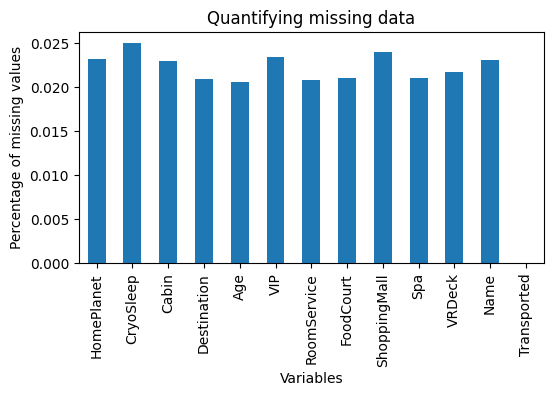

In [5]:
train.isnull().mean().plot.bar(figsize=(6,3)) 
plt.ylabel('Percentage of missing values') 
plt.xlabel('Variables') 
plt.title('Quantifying missing data')

In [7]:
# check the Train features with missing values
nan_columns_train = [i for i in train.columns if train[i].isnull().any()]
print(train.isnull().sum())
print()
print("There are" + str(len(nan_columns_train)) + " columns with NAN values.")
nan_columns

# check the Test features with missing values
nan_columns_test = [i for i in test.columns if test[i].isnull().any()]
print(test.isnull().sum())
print()
print("There are " + str(len(nan_columns_test)) +" columns with NAN values.")
nan_columns_test

HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

There are12 columns with NAN values.
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

There are 12 columns with NAN values.


['HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Name']

In [8]:
# generate feature from cabin for train
train['Deck'] =  train['Cabin'].str.split('/').str[0]
train['Num'] =  train['Cabin'].str.split('/').str[1]
train['Port'] =  train['Cabin'].str.split('/').str[-1]

# generate feature from cabin for test
test['Deck'] =  test['Cabin'].str.split('/').str[0]
test['Num'] =  test['Cabin'].str.split('/').str[1]
test['Port'] =  test['Cabin'].str.split('/').str[-1]

In [9]:
# Drop target variable
train_without_target = train.drop(columns=['Transported', 'Name', 'Cabin', 'Num'])

test = test.drop(columns=['Name', 'Cabin', 'Num'])

In [14]:
num_feature = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", RobustScaler())]
)

cat_feature = ['HomePlanet', 'CryoSleep',  'Destination', 'VIP','Deck', 'Port']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# prepare
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_feature),
        ("cat", categorical_transformer, cat_feature),
    ]
)

# model
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", GradientBoostingClassifier(n_estimators = 114, 
                                                                                     min_samples_split = 7,
                                                                                     min_samples_leaf = 5))]
)

#train/test split
X_train, X_validation, Y_train, y_validation = train_test_split(train_without_target, target, random_state=0, train_size = .75)

clf.fit(X_train, Y_train)
print(accuracy_score(clf.predict(X_validation), y_validation))
clf.predict(test)

0.7999080036798528


array([ True, False,  True, ...,  True,  True,  True])

In [15]:
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP', 'Deck',
                                                   'Port'])])),
                ('sampling', SMOTE()),
                ('classifier',
                 GradientBoostingClassifier(min_samples_leaf=5,
                                            min_samples_split=7,
                                            n_estimators=114))])

In [ ]:
# find best params for boosting

import optuna

if __name__ == "__main__":
    clf = GradientBoostingClassifier()

    param_distributions = {
        
        'n_estimators': optuna.distributions.IntDistribution(1, 1000, log=True), 
        'min_samples_split' : optuna.distributions.IntDistribution(2, 10),
        'min_samples_leaf': optuna.distributions.IntDistribution(1, 5)
    }

    optuna_search = optuna.integration.OptunaSearchCV(
        clf, param_distributions, n_trials=100, timeout=600, verbose=2
    )

    optuna_search.fit(X_train, Y_train)

    print("Best trial:")
    trial = optuna_search.study_.best_trial

    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [ ]:
# best params is:
# n_estimators = 114, 
# min_samples_split = 7,
# min_samples_leaf = 5